## Importing the libraries

In [19]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import numpy as np

## Importing and preparing the dataset

In [11]:
# Change location code to the location required to train on for LSTM time series weather forecasting
location_code = "kuala-lumpur"
hourly_dataframe = pd.read_csv(f'../../datasets/{location_code}/weather_data_hourly.csv')

In [12]:
hourly_dataframe.head()

,date,temperature_2m,relative_humidity_2m,dew_point_2m,rain,pressure_msl,wind_speed_10m,wind_direction_10m
0,2010-01-01 00:00:00+00:00,23.257000,98.20215,22.957000,0.0,1008.6,4.213692,109.98319
1,2010-01-01 01:00:00+00:00,24.607000,94.45848,23.657000,0.0,1009.3,3.600000,143.13002
2,2010-01-01 02:00:00+00:00,25.457000,89.25246,23.557001,0.0,1010.0,5.154415,155.22488
3,2010-01-01 03:00:00+00:00,26.357000,82.10335,23.057001,0.0,1010.2,4.680000,157.38010
4,2010-01-01 04:00:00+00:00,26.807001,80.19705,23.107000,0.2,1009.9,3.545589,156.03750


In [13]:
hourly_dataframe.columns

Index(['date', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'rain', 'pressure_msl', 'wind_speed_10m', 'wind_direction_10m'],
      dtype='object')

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

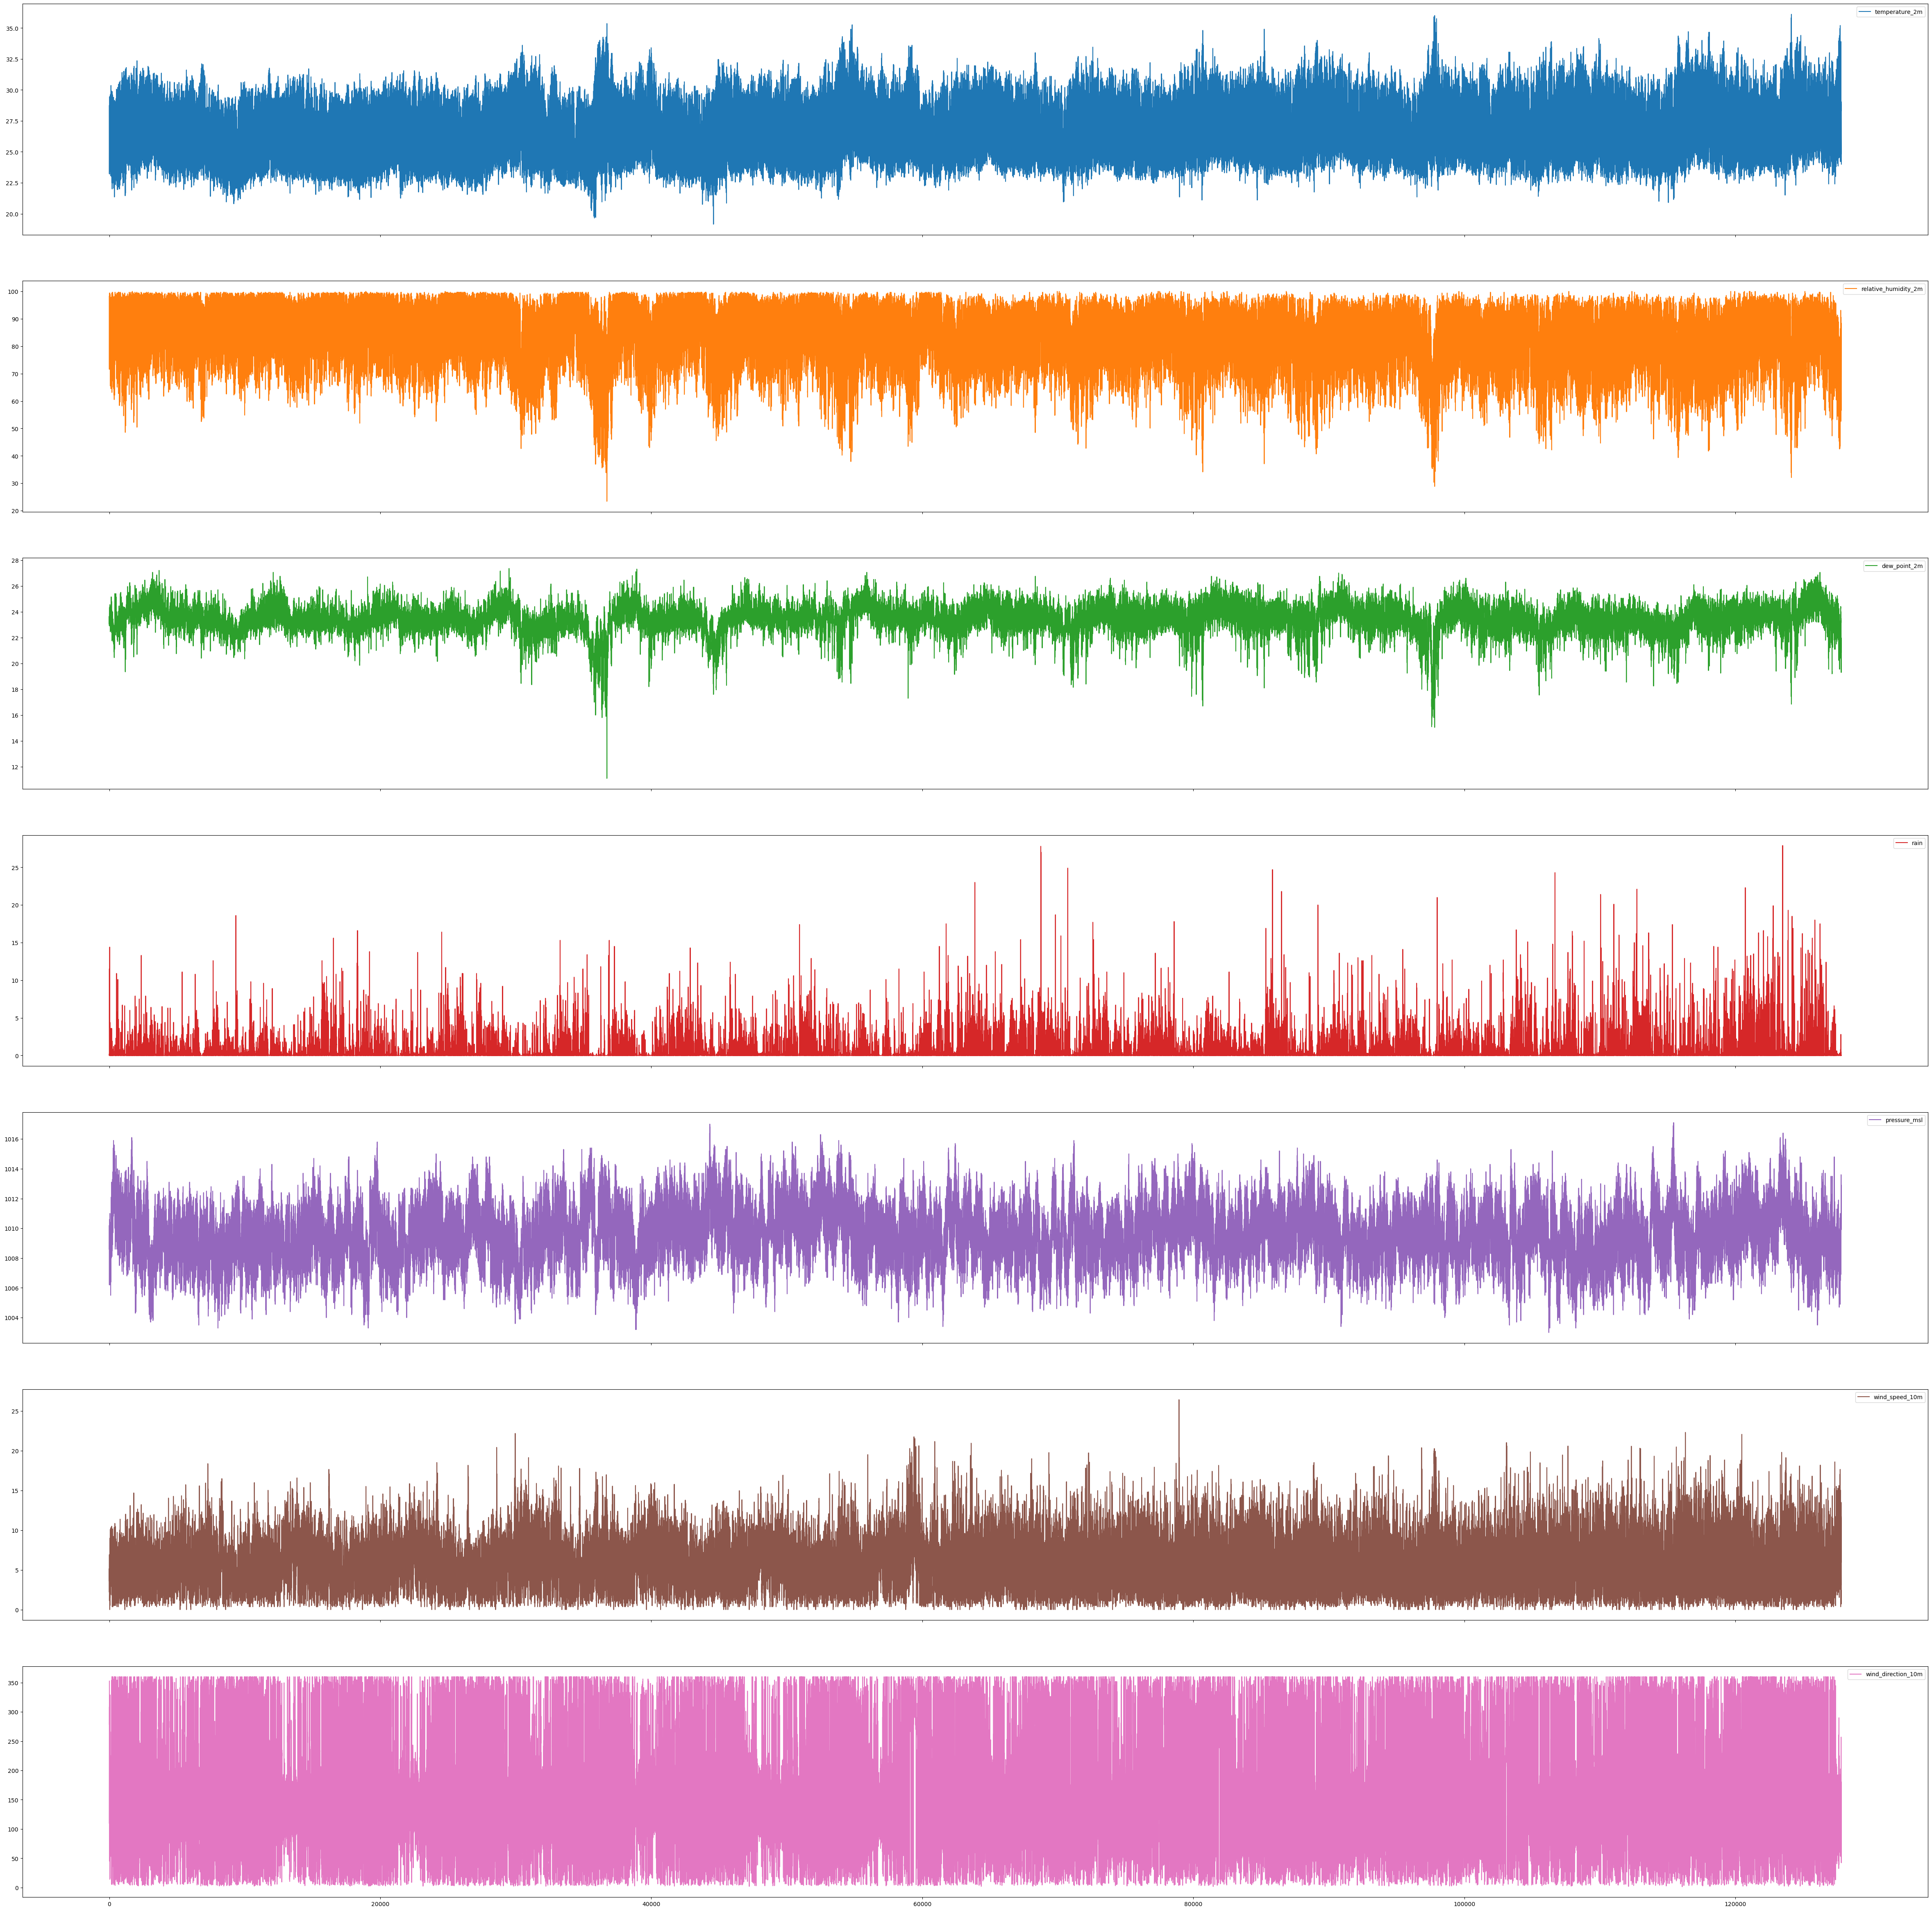

In [42]:
hourly_dataframe[['temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'rain', 'pressure_msl', 'wind_speed_10m', 'wind_direction_10m']].plot(subplots=True, figsize=(60, 60))

In [14]:
# Train Test split of 70-10-20 (train-eval-test) for LSTM training
training_size = int(0.70 * hourly_dataframe.shape[0])  
evaluation_size = int(0.10 * hourly_dataframe.shape[0])
testing_size = hourly_dataframe.shape[0] - training_size - evaluation_size

print("Training Size: ", training_size)
print("Evaluation Size: ", evaluation_size)
print("Testing Size: ", testing_size)
print("Total Size: ", hourly_dataframe.shape[0])

Training Size:  89476
Evaluation Size:  12782
Testing Size:  25566
Total Size:  127824


## Feature Selection Using Correlation Analysis

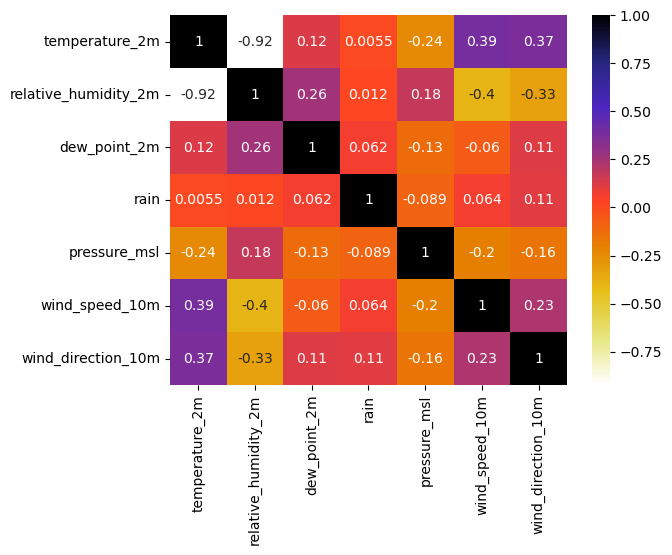

In [15]:
cor = hourly_dataframe.iloc[:training_size].drop(columns=['date']).corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

Text(0, 0.5, 'Value')

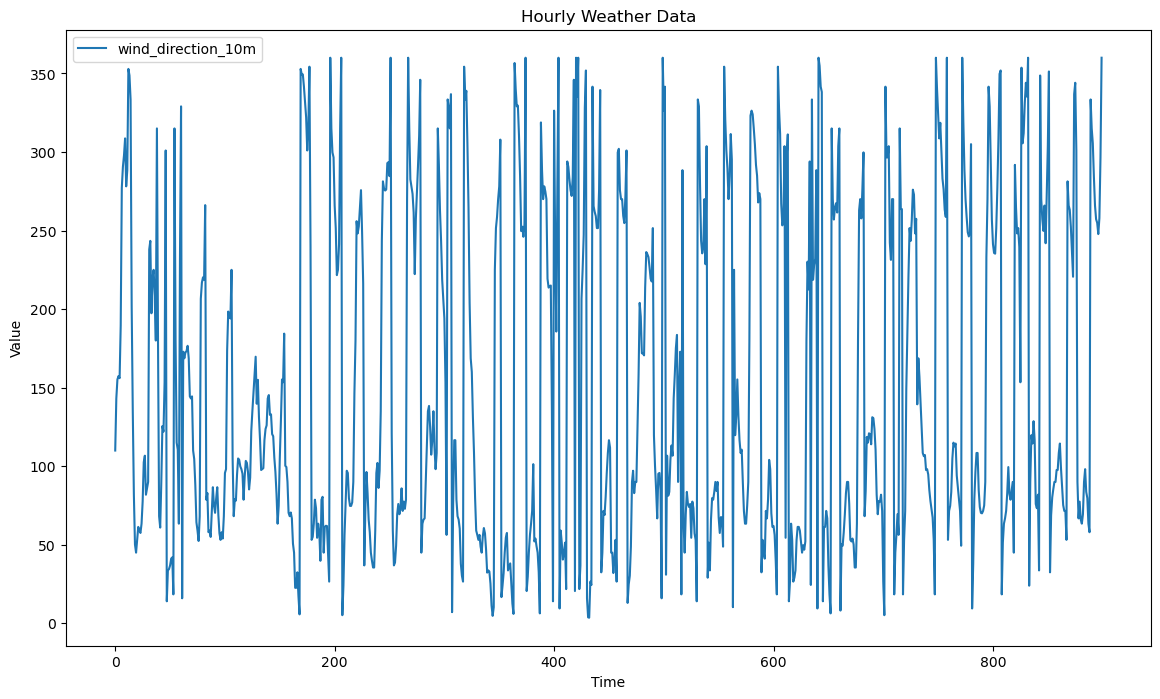

In [43]:
# Temperature dependent variable: Drop rain based on correlation matrix

hourly_dataframe[['date', 'wind_direction_10m']].head(900).plot(kind='line', figsize=(14, 8))
plt.title('Hourly Weather Data')
plt.xlabel('Time')
plt.ylabel('Value')

## Splitting the dataset into the Training set and Test set

In [16]:
final_hourly_dataframe = hourly_dataframe.drop(columns=['date', 'rain'])

In [8]:
# Splitting and preparing the train and test dataframes
# Function to convert data into sequences
def make_sequence(data, label_col, window_size =  72):

    sequences = []
    labels = []

    for i in range(data.shape[0] - window_size):
        sequences.append(data[i:i+window_size])
        labels.append(data.iloc[i+window_size][label_col])
        
    return sequences, labels

In [24]:
training_dataset = final_hourly_dataframe.iloc[:training_size]
evaluation_dataset = final_hourly_dataframe.iloc[training_size:training_size+evaluation_size]
testing_dataset = final_hourly_dataframe.iloc[training_size+evaluation_size:]

training_dataset.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,pressure_msl,wind_speed_10m,wind_direction_10m
0,23.257000,98.20215,22.957000,1008.6,4.213692,109.98319
1,24.607000,94.45848,23.657000,1009.3,3.600000,143.13002
2,25.457000,89.25246,23.557001,1010.0,5.154415,155.22488
3,26.357000,82.10335,23.057001,1010.2,4.680000,157.38010
4,26.807001,80.19705,23.107000,1009.9,3.545589,156.03750


## Feature Scaling

In [45]:
scaler = MinMaxScaler() # Default feature range [0, 1]

# Fit scalar to training dataset
scaled_training_dataset = pd.DataFrame(scaler.fit_transform(training_dataset), columns=training_dataset.columns)


# Scale the evaluation and testing datasets using the same training scaler
scaled_evalutation_dataset = pd.DataFrame(scaler.transform(evaluation_dataset), columns=evaluation_dataset.columns)
scaled_testing_dataset = pd.DataFrame(scaler.transform(testing_dataset), columns=testing_dataset.columns)


scaled_training_dataset.head()

temperature_2m          12782
relative_humidity_2m    12782
dew_point_2m            12782
pressure_msl            12782
wind_speed_10m          12782
wind_direction_10m      12782
dtype: int64

In [53]:
scaled_testing_dataset.iloc[[72]]

,temperature_2m,relative_humidity_2m,dew_point_2m,pressure_msl,wind_speed_10m,wind_direction_10m
72,0.207237,0.864338,0.54902,0.48227,0.148741,0.281946


In [48]:
sequences, labels = make_sequence(scaled_testing_dataset.iloc[:73, :], 'temperature_2m')
# Convert to np array
sequences = np.array(sequences)
print(sequences.shape)
# print(len(sequences), len(labels))
# hourly_dataframe.iloc[:73, :].shape[0]
# print(sequences[0])
# print(sequences)
print(labels)
print(len(labels))
print(type(labels))

(1, 72, 6)
[np.float64(0.20723684210526327)]
1
<class 'list'>


In [51]:
scaled_training_dataset.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,pressure_msl,wind_speed_10m,wind_direction_10m
0,0.253086,0.976523,0.729231,0.391304,0.159443,0.302039
1,0.336420,0.927637,0.772308,0.442029,0.136222,0.394573
2,0.388889,0.859655,0.766154,0.492754,0.195040,0.428338
3,0.444444,0.766299,0.735385,0.507246,0.177088,0.434355
4,0.472222,0.741406,0.738462,0.485507,0.134163,0.430607


In [67]:

X_train, y_train = make_sequence(scaled_training_dataset, 'temperature_2m')
X_eval, y_eval = make_sequence(scaled_evalutation_dataset, 'temperature_2m')
X_test, y_test = make_sequence(scaled_testing_dataset, 'temperature_2m')

In [68]:
print(np.array(X_test).shape)
X_test[0]
print(type(X_test[0]))
# y_test[0]
# print(type(X_test))
# Convert X test to np array and get last array


(25494, 72, 6)
<class 'pandas.core.frame.DataFrame'>


In [75]:
print(np.array(X_test)[-1][-2])
print(y_test[-2])

[0.2203948  0.80098925 0.49019608 0.53900709 0.108225   0.32109097]
0.20723684210526327


In [65]:
scaled_testing_dataset.tail()

,temperature_2m,relative_humidity_2m,dew_point_2m,pressure_msl,wind_speed_10m,wind_direction_10m
25561,0.269737,0.690499,0.416667,0.595745,0.068448,0.121505
25562,0.253290,0.726221,0.441176,0.567376,0.032266,0.247005
25563,0.220395,0.800989,0.490196,0.539007,0.108225,0.321091
25564,0.207237,0.804609,0.475490,0.560284,0.098135,0.273394
25565,0.203947,0.828153,0.500000,0.595745,0.080666,0.498003


In [ ]:
# Number of windows from n sized array with k window size, no +1 since we want the next predicted value
# n - k

## Create Model and Train

In [74]:
89476 - 72

np.array(X_train).shape
89476 - 72

89404

## Evaluate Model

## Export Model and Scaler